In this notebook I will extract the density of the functional group that might be in the active layer.


In [2]:
import os
import numpy as np
import pandas as pd
from scipy import signal
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
import matplotlib
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import random
import pylab
import glob
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime

import inverse_method_funs as inv

In [3]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

# Read wideband frequency response
Read the Echoview export of wideband frequency response. sv pulse compressed.

In [4]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/Flaket_SSL/*.csv')

sv_all = np.zeros((820,0))
times = np.zeros((0))
for ind in np.arange(len(fname_EV)):
    print(fname_EV[ind])
    freqs_EV, sv_out, times_out = inv.read_widebandfrequencyresponse(fname_EV[ind])

    sv_all = np.append(sv_all, sv_out, axis=1)
    times = np.append(times, times_out)
    

F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_210618_1030.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_210618_1100.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_210618_1130.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_210618_800.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_210618_830.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_210618_900.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_240618_2000.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_240618_2100.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_240618_2130.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_240618_2200.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_250618_0000.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_250618_0030.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_250618_0130.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_250618_0230.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_250618_0330.csv
F:/GLIDER2018/Echosounder/Flaket_SSL\Wideband_250618_0500.csv
F:/GLIDER20

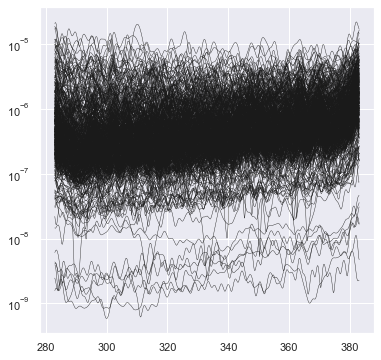

In [5]:
plt.figure(figsize=(6,6))
plt.semilogy(freqs_EV, sv_all, 'k', linewidth = 0.4);

# Read scattering models
Import species backscattering cross section matrix

In [6]:
# Sigmabs from ZooScatR model runs + viscous elactic model for mean of fish larvae model by ve=True)
fname_sim = '../ZooScatStuff/my_simplified_data.feather'
specs, freqs_sim, sig_bs_mean = inv.read_scatteringmodelsimulations(fname_sim, nsim=1000, ve=True)

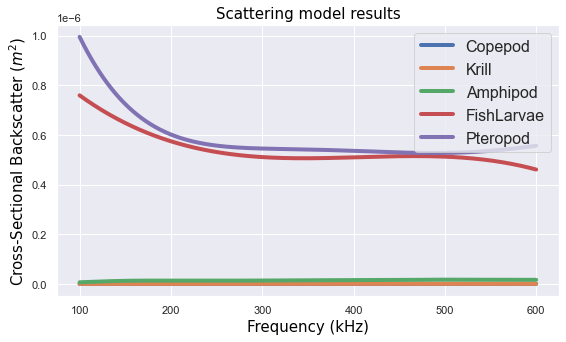

In [7]:
fig=plt.figure(figsize=(9, 5),facecolor='w', edgecolor='k')
plt.plot(freqs_sim,sig_bs_mean, linewidth=4)
plt.legend(specs, fontsize=16)
plt.ylabel('Cross-Sectional Backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

In [8]:
sig_bs_mean[373,0]


2.0074749849876194e-10

# Resample to line up output and input

In [9]:
sigbs_mean = np.zeros([len(freqs_EV),len(specs)])


for ind_spec in range(0,len(specs)):
    sigbs_mean[:,ind_spec] = np.interp(freqs_EV, freqs_sim, sig_bs_mean[:,ind_spec])

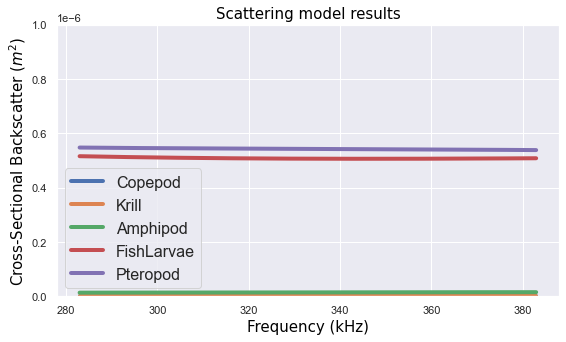

In [10]:
fig=plt.figure(figsize=(9, 5),facecolor='w', edgecolor='k')
plt.plot(freqs_EV,sigbs_mean, linewidth=4)
plt.legend(specs, fontsize=16)
plt.ylim([0,1e-6])
plt.ylabel('Cross-Sectional Backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Scattering model results', title_font);

# IIM

Run a least squares solver

In [11]:
density = np.zeros([np.shape(sigbs_mean)[1], np.shape(sv_all)[1]])
sigbs = sigbs_mean
for ind in range(0, np.shape(sv_all)[1]):
    d = optimize.lsq_linear(sigbs, sv_all[:,ind], bounds=(0,np.inf))
    density[:,ind] = d.x

In [12]:
np.mean(density,1)




array([ 69.80195518, 420.72693596,   6.62740679,   0.65683315,
         0.74283142])

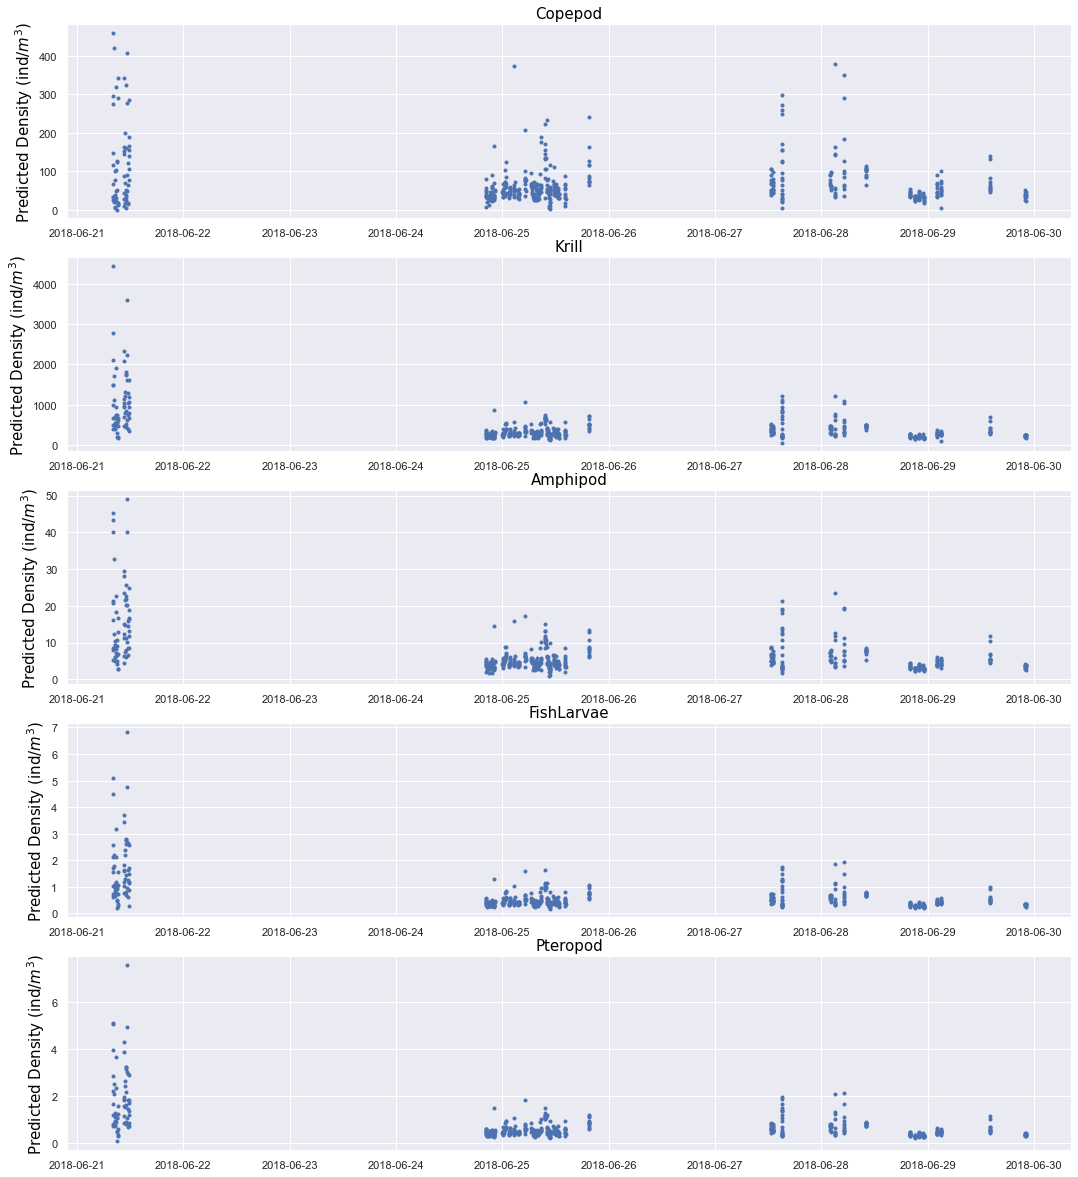

In [13]:
plt.figure(figsize=(18, 25),facecolor='w', edgecolor='k')
plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)
plt.xlabel('Functional group', axis_font)
for ind in range(0,len(specs)):
    plt.subplot(len(specs)+1,1,ind+1)
    plt.plot(times, density[ind,:], '.')
    plt.title(specs[ind], title_font)
    plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)

## Load lat/lon

In [14]:
SB_env_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SB_env_tromsøflaket2018.xlsx',header=0, engine="openpyxl")


In [15]:
SB_env_times = SB_env_df.set_index(['datetime'])

In [16]:
index = []
for ind in range(len(times)):
    ind_index = SB_env_times.index.get_loc(times[ind], method="nearest")
    index = np.append(index, ind_index)

# Make dataframe

In [17]:
data = pd.DataFrame()

for specs_ind in range(len(specs)):
    for ind in range(len(times)):
        SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
        data = data.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            'density': density[specs_ind,ind],
                            'species': specs[specs_ind],                        
                            'source': 'IIM'}, 
                            'ignore_index=True')

## Add net data

In [18]:
SP_stations_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SeaPatchesStations.xlsx',header=0)
tucker_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/Tucker Trawl.xlsx', header=79)
multinet_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SP_Multinet.xlsx')

In [19]:
#Station 7 from Tucker Trawl
stn = 7
for stn_ind in range(7,17):
    for ind_spec in [0,1,2,3,5]:
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': tucker_density['Station ' + str(stn_ind)][ind_spec],
                            'species': tucker_density['Species'][ind_spec],
                            'source': 'TuckerTrawl'}, 
                            'ignore_index=True')
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': multinet_density['Stn ' + str(stn_ind)][ind_spec],
                            'species': multinet_density['Species'][ind_spec],
                            'source': 'Multinet'}, 
                            'ignore_index=True')

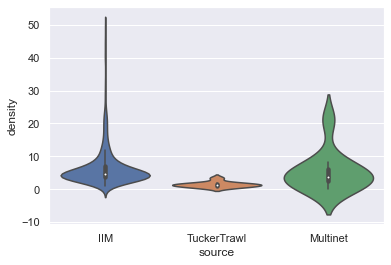

In [20]:
sns.violinplot(data=data[data.species=='Amphipod'], x='source', y='density', scale='width')

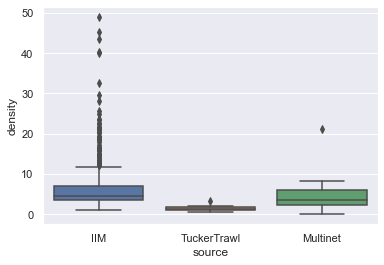

In [21]:
sns.boxplot(data=data[data.species=='Amphipod'], x='source', y='density')

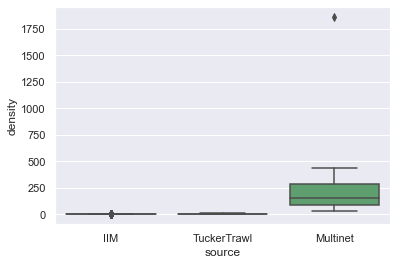

In [23]:
sns.boxplot(data=data[data.species=='Pteropod'], x='source', y='density')

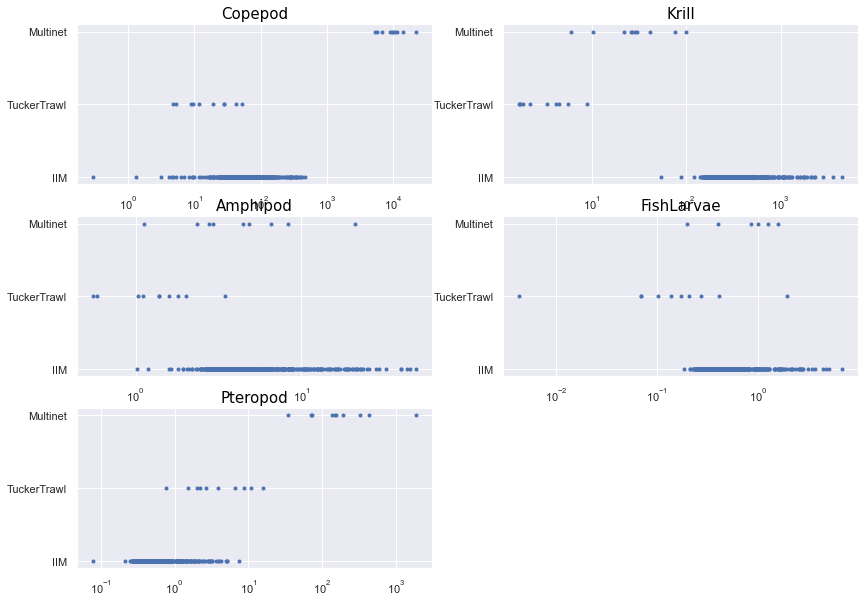

In [24]:
fig = plt.figure(figsize=(14,10))
for ind_spec in range(len(specs)):
    ax = plt.subplot(3,2,ind_spec+1)
    ax.semilogx(data.density[data.species==specs[ind_spec]],data.source[data.species==specs[ind_spec]], '.')
    ax.set_title(specs[ind_spec], title_font)

# Set up per species data

In [25]:
data_spec = pd.DataFrame()

for ind in range(len(times)):
    specs_ind=0
    SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
    data_spec = data_spec.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            specs[specs_ind]: density[specs_ind, ind],
                            specs[specs_ind+1]: density[specs_ind+1, ind],
                            specs[specs_ind+2]: density[specs_ind+2, ind],
                            specs[specs_ind+3]: density[specs_ind+3, ind],
                            specs[specs_ind+4]: density[specs_ind+4, ind],
                            'source': 'IIM'}, 
                            'ignore_index=True')

In [26]:
#Dataframe with all species
for stn_ind in range(7,17):
    data_spec = data_spec.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                        'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                        'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                        tucker_density['Species'][0]: tucker_density['Station ' + str(stn_ind)][0],
                        tucker_density['Species'][1]: tucker_density['Station ' + str(stn_ind)][1],
                        tucker_density['Species'][2]: tucker_density['Station ' + str(stn_ind)][2],
                        tucker_density['Species'][3]: tucker_density['Station ' + str(stn_ind)][3],
                        tucker_density['Species'][5]: tucker_density['Station ' + str(stn_ind)][5],
                        'source': 'TuckerTrawl'}, 
                        'ignore_index=True')
    data_spec = data_spec.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                        'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                        'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                        multinet_density['Species'][0]: multinet_density['Stn ' + str(stn_ind)][0],
                        multinet_density['Species'][1]: multinet_density['Stn ' + str(stn_ind)][1],
                        multinet_density['Species'][2]: multinet_density['Stn ' + str(stn_ind)][2],
                        multinet_density['Species'][3]: multinet_density['Stn ' + str(stn_ind)][3],
                        multinet_density['Species'][5]: multinet_density['Stn ' + str(stn_ind)][5],
                        'source': 'Multinet'}, 
                        'ignore_index=True')

In [27]:
data_spec

,Amphipod,Copepod,FishLarvae,Krill,Pteropod,datetime,lat,lon,source
0,6.393805,26.572213,0.772205,467.296381,0.873663,2018-06-21 10:31:37,70.830452,18.02643,IIM
1,12.385861,152.014567,1.020310,680.608263,1.136936,2018-06-21 10:33:02,70.830452,18.02643,IIM
2,23.564367,342.679602,1.820221,1135.961987,1.958525,2018-06-21 10:34:27,70.830452,18.02643,IIM
3,11.224316,9.412094,1.639337,954.088857,1.865681,2018-06-21 10:35:52,70.830452,18.02643,IIM
4,29.529220,162.613299,3.434020,2096.235980,3.881241,2018-06-21 10:37:18,70.830452,18.02643,IIM
...,...,...,...,...,...,...,...,...,...
516,2.771429,10670.971429,0.000000,30.209524,154.876190,2018-06-24 02:14:00,70.091000,18.16900,Multinet
517,2.002157,5.316073,0.103560,1.725998,1.518878,2018-06-24 10:57:00,70.525000,18.16600,TuckerTrawl
518,4.840286,5393.234286,0.000000,28.633429,325.102571,2018-06-24 10:57:00,70.525000,18.16600,Multinet
519,0.586839,11.598706,0.172600,4.453074,3.866235,2018-06-25 05:35:00,70.500000,16.93600,TuckerTrawl


In [28]:
data

,datetime,density,lat,lon,source,species
0,2018-06-21 10:31:37,26.572213,70.830452,18.02643,IIM,Copepod
1,2018-06-21 10:33:02,152.014567,70.830452,18.02643,IIM,Copepod
2,2018-06-21 10:34:27,342.679602,70.830452,18.02643,IIM,Copepod
3,2018-06-21 10:35:52,9.412094,70.830452,18.02643,IIM,Copepod
4,2018-06-21 10:37:18,162.613299,70.830452,18.02643,IIM,Copepod
...,...,...,...,...,...,...
2600,2018-06-25 05:35:00,1.120000,70.500000,16.93600,Multinet,Amphipod
2601,2018-06-25 05:35:00,3.866235,70.500000,16.93600,TuckerTrawl,Pteropod
2602,2018-06-25 05:35:00,34.971429,70.500000,16.93600,Multinet,Pteropod
2603,2018-06-25 05:35:00,0.172600,70.500000,16.93600,TuckerTrawl,FishLarvae


In [29]:
# Send to R
data.to_feather('.\SSL_density.feather')
data_spec.to_feather('.\SSL_density_spec.feather')

In [30]:
x = data.amphipod #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

AttributeError: 'DataFrame' object has no attribute 'amphipod'